# **Best Mapping Fields for Distance Based Model from 1D Channel Flow Simulation**

This notebook demonstrates how to create a distance based ML model for finding wall slope, which is modified from [the notebook](https://github.com/JihooKang-KOR/Data_driven_wall_modeling/blob/main/notebooks/BestMapping_1DChannel.ipynb).

In [1]:
from itertools import cycle
from typing import List, Tuple
from os.path import isdir
import numpy as np
import torch as pt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Make results reproducible
pt.manual_seed(0)
# Increase plot resolution
plt.rcParams["figure.dpi"] = 160
# Set paths and create output directory
run = "../run/"
output = "output/2DflatPlate"
!mkdir -p $output

## 1. Data loading

In [2]:
ccVel_path = run + 'channelFlow1D_1.388_69.4/extractData_cellCenterVel.csv'
ccVel_data = pd.read_csv(ccVel_path, delim_whitespace=False)

# To transform y-coordinates (y_face) to elements of the csv file
ccVel_data = ccVel_data.set_index('y_center').T.rename_axis('y_center').rename_axis(None, axis=1).reset_index()
ccVel_data.head()

,y_center,y_face_approx,0.0002sec_Ux_center,0.0002sec_dUdy_wall,0.0004sec_Ux_center,0.0004sec_dUdy_wall,0.0006sec_Ux_center,0.0006sec_dUdy_wall,0.0008sec_Ux_center,0.0008sec_dUdy_wall,...,0.096sec_Ux_center,0.096sec_dUdy_wall,0.097sec_Ux_center,0.097sec_dUdy_wall,0.098sec_Ux_center,0.098sec_dUdy_wall,0.099sec_Ux_center,0.099sec_dUdy_wall,0.1sec_Ux_center,0.1sec_dUdy_wall
0,4.6866677865e-06,0.000009,4.40001,938835.4798,3.99304,851999.796423,3.80645,812186.861412,3.65549,779976.342793,...,1.43128,305393.952634,1.42701,304482.857546,1.42274,303571.762457,1.41852,302671.33593,1.41410,301728.23516
1,1.40775972765e-05,0.000028,13.13420,938835.4798,11.95070,851999.796423,11.39700,812186.861412,10.94870,779976.342793,...,4.29702,305393.952634,4.28422,304482.857546,4.27140,303571.762457,4.25874,302671.33593,4.24550,301728.23516
2,2.3503780655e-05,0.000047,21.45630,938835.4798,19.61840,851999.796423,18.73550,812186.861412,18.02060,779976.342793,...,7.15716,305393.952634,7.13594,304482.857546,7.11470,303571.762457,7.09371,302671.33593,7.07174,301728.23516
3,3.296535027e-05,0.000066,28.77230,938835.4798,26.40390,851999.796423,25.26910,812186.861412,24.35860,779976.342793,...,9.96938,305393.952634,9.94020,304482.857546,9.91101,303571.762457,9.88216,302671.33593,9.85194,301728.23516
4,4.2462438955e-05,0.000085,34.75920,938835.4798,31.86240,851999.796423,30.52820,812186.861412,29.48800,779976.342793,...,12.65470,305393.952634,12.61860,304482.857546,12.58250,303571.762457,12.54690,302671.33593,12.50950,301728.23516


In [3]:
# Constants
nu = 1.388e-5
D = 2.0 # Diameter of the channel / Length of the plate
Uinput = 69.4

In [4]:
# End time of OpenFOAM simulation
end_time1 = 0.01 # 50 steps with 0.0002 write interval
end_time2 = 0.1 # 90 steps with 0.001 write interval

# Number of divided time steps, not the actual time
num_step = int((len(ccVel_data.columns) - 1)/2.0)

# Number of divided y-coordinates
num_yface = len(ccVel_data)

# Change from string to numeric values
ccVel_data['y_face'] = pd.to_numeric(ccVel_data['y_face_approx'], errors='coerce')
for i in range(num_step):    
    ccVel_data.iloc[:, 2*(i+1)] = pd.to_numeric(ccVel_data.iloc[:, 2*(i+1)], errors='coerce')
    ccVel_data.iloc[:, 2*(i+1) + 1] = pd.to_numeric(ccVel_data.iloc[:, 2*(i+1) + 1], errors='coerce')

# Save the related data to pytorch tensors
y_face = pt.tensor(ccVel_data['y_face'])
U_center = pt.tensor([ccVel_data.iloc[:, 2*(i+1)] for i in range(num_step)]).T
dUdy_wall = pt.tensor([ccVel_data.iloc[:, 2*(i+1) + 1] for i in range(num_step)]).T

# Number of features
num_feature = 2

## 2. Machine learning

#### Parameters : lr = 0.001, number of neurons per layer = 50, number of hidden layers = 5, activation function = ReLU.

In [5]:
# Reshape features
def reshape_features(y_face: pt.Tensor, U_center: pt.Tensor) -> pt.Tensor:
    """Create feature vectors.

    Features
    ------
    :param y_face: distance from the wall at the face
    :type y: pt.Tensor
    :param U_center: cell center velocity profiles
    :type U_center: pt.Tensor
    
    Return
    ------
    :return: data suitable for training; if there are Ny points normal to
        the wall and Nu different average velocities, the resulting tensor
        has the shape (Ny*Nu, 2)
    :rtype: pt.Tensor
    """
    assert y_face.shape[0] == U_center.shape[0]    
    data = pt.zeros((U_center.shape[0]*U_center.shape[1], 2))
    for i in range(U_center.shape[1]):
        start, end = i*U_center.shape[0], (i+1)*U_center.shape[0]        
        data[start:end, 0] = y_face
        data[start:end, 1] = U_center[:, i]
    return data

# Reshape label
def reshape_label(dUdy_wall: pt.Tensor) -> pt.Tensor:
    """Create label vector.

    Labels
    -------
    :param dUdy_wall: velocity gradient at wall
    :type dUdy_wall: pt.Tensor    
    
    Return
    ------
    :return: data suitable for training; if there are Ny points normal to
        the wall and Nu different time steps, the resulting tensor
        has the shape (Ny*Nu, 1)
    :rtype: pt.Tensor
    """    
    data = pt.zeros((dUdy_wall.shape[0]*dUdy_wall.shape[1], 1))
    for i in range(dUdy_wall.shape[1]):
        start, end = i*dUdy_wall.shape[0], (i+1)*dUdy_wall.shape[0]
        data[start:end, 0] = dUdy_wall[:, i]        
    return data

In [6]:
# Correlation heat map for the features and the labels
true_data = pt.cat((reshape_label(dUdy_wall), reshape_features(y_face, U_center)), axis=1)
true_data_pd = pd.DataFrame(np.array(true_data), columns = ['dUdy_wall','y_face','U_center'])
data_cor = true_data_pd.corr()
data_cor.style.background_gradient(cmap='coolwarm').format(precision=4)

,dUdy_wall,y_face,U_center
dUdy_wall,1.0000,0.0000,0.6673
y_face,0.0000,1.0000,0.5940
U_center,0.6673,0.5940,1.0000


In [7]:
# Divide the data into 3 parts by using a multinomial method
# 60% train, 20% validation, 20% test sets
probs = pt.ones(dUdy_wall.shape[-1])
test_idx = pt.multinomial(probs, 28)
probs[test_idx] = 0.0
val_idx = pt.multinomial(probs, 28)
probs[val_idx] = 0.0
train_idx = pt.multinomial(probs, probs.shape[0] - 56)
print("Testing snapshots: ", test_idx)
print("Validation snapshots: ", val_idx)
print("Training snapshots: ", train_idx)

Testing snapshots:  tensor([ 58,  74, 128,  93,  47,  41, 115,  61, 124, 122, 129, 135,  22,  68,
        131,  65, 113,  33,  79,  77,  62, 100,  95,  11,  96,   6,  97,  83])
Validation snapshots:  tensor([111, 117,  28, 118,  10,  90,  53,  30,   4,   7,   0, 104, 105,  80,
        138,  75,  42,  67,  84,  81,  43,  71,  39,  82,  70,  88, 120,  27])
Training snapshots:  tensor([ 24, 126,  49,  86,  23,   3, 125,  55, 103,  89,  91,  45,  14, 121,
        106,  78,  87, 114,  85,  21,  36,  98,  56,  26,  99,  34, 119,  46,
         63,  16,   5, 101, 136,  15,  29,  38,   2, 132,  52, 110, 102,  72,
        107,  37,  60,  35,  73,  76,  18,  94,  57,  66,  25,  20,  40,   1,
          9,  48, 139, 137,   8, 127,  12,  59,  54,  17, 112,  19, 116,  13,
         44,  32,  92,  69, 134,  51,  31, 130, 133, 123,  64, 108, 109,  50])


In [8]:
# Create a neural network
class MappingNN(pt.nn.Module):
    """A fully-connected base neural network.
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.n_inputs = kwargs.get("n_inputs", 1)
        self.n_outputs = kwargs.get("n_outputs", 1)
        self.n_layers = kwargs.get("n_layers", 1)
        self.n_neurons = kwargs.get("n_neurons", 10)
        self.activation = kwargs.get("activation", pt.sigmoid)
        self.layers = pt.nn.ModuleList()
        # Input layer to first hidden layer
        self.layers.append(pt.nn.Linear(self.n_inputs, self.n_neurons))
        # Add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(pt.nn.Linear(
                    self.n_neurons, self.n_neurons))
        # Last hidden layer to output layer
        self.layers.append(pt.nn.Linear(self.n_neurons, self.n_outputs))

    def forward(self, x):
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

    @property
    def model_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [9]:
# Derived NN class for feature min-max scaling
class FeatureScalerModel(MappingNN):
    """Scaling model for features.
    """
    def __init__(self, xmin, xmax, **kwargs):
        super(FeatureScalerModel, self).__init__(**kwargs)
        self._xmin = xmin
        self._xmax = xmax
        self._range = xmax - xmin        
        
    def scale(self, x):
        return (x - self._xmin) / self._range

    def forward(self, x):
        # Non-dimensionalized features
        x = pt.cat(((x[:, 0]/D).unsqueeze(1), (x[:, 1]/Uinput).unsqueeze(1)), dim=1)
        # Min-Max scaling
        x = self.scale(x)        
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

In [10]:
# Scaler for labels
class LabelScaler(object):
    """Class to scale/re-scale data to the range [0, 1] and back.
    """
    def __init__(self):
        self.min = None
        self.max = None
        self.trained = False

    def fit(self, data):
        self.min = data.min(dim=0).values
        self.max = data.max(dim=0).values
        self.trained = True

    def scale(self, data):
        assert self.trained
        assert len(data.shape) == 2
        data_norm = (data - self.min) / (self.max - self.min)
        return data_norm

    def rescale(self, data_norm):
        assert self.trained
        assert len(data_norm.shape) == 2
        data = data_norm * (self.max - self.min) + self.min
        return data

In [11]:
# Feature division
train_features = reshape_features(y_face, U_center[:, train_idx])
val_features = reshape_features(y_face, U_center[:, val_idx])
test_features = reshape_features(y_face, U_center[:, test_idx])

# Label division
train_label_raw = reshape_label(pt.log1p(dUdy_wall[:, train_idx]*D/Uinput))
val_label_raw = reshape_label(pt.log1p(dUdy_wall[:, val_idx]*D/Uinput))
test_label_raw = reshape_label(pt.log1p(dUdy_wall[:, test_idx]*D/Uinput))

# Label scaling
scaler = LabelScaler()
scaler.fit(train_label_raw)
train_label = scaler.scale(train_label_raw)
val_label = scaler.scale(val_label_raw)
test_label = scaler.scale(test_label_raw)

# Check if the normalization works
assert pt.isclose(train_label.min(), pt.tensor(0.0))
assert pt.isclose(train_label.max(), pt.tensor(1.0))
assert pt.allclose(train_label_raw, scaler.rescale(train_label))

# Creation of tensors including features and label
train_wall = pt.cat((train_features, train_label), dim=1).double()
val_wall = pt.cat((val_features, val_label), dim=1).double()
test_wall = pt.cat((test_features, test_label), dim=1).double()

In [12]:
# Model optimization function
def optimize_model(model: pt.nn.Module, x_train: pt.Tensor, y_train: pt.Tensor,
                   x_val: pt.Tensor, y_val: pt.Tensor, epochs: int=1000,
                   lr: float=0.001, save_best: str="") ->Tuple[List[float], List[float]]:
    """Optimize network weights based on training and validation data.

    Parameters
    ----------
    :param model: neural network model
    :type model: pt.nn.Module
    :param x_train: features for training
    :type x_train: pt.Tensor
    :param y_train: labels for training
    :type y_train: pt.Tensor
    :param x_val: features for validation
    :type x_val: pt.Tensor
    :param y_val: labels for validation
    :type y_val: pt.Tensor
    :param epochs: number of optimization loops, defaults to 1000
    :type epochs: int, optional
    :param lr: learning rate, defaults to 0.001
    :type lr: float, optional
    :param save_best: path where to save best model; no snapshots are saved
        if empty string; defaults to ""
    :type save_best: str, optional
    
    Return
    ------
    :return: lists with training and validation losses for all epochs
    :rtype: Tuple[List[float], List[float]]
    """
    criterion = pt.nn.MSELoss()
    optimizer = pt.optim.Adam(params=model.parameters(), lr=lr)
    best_val_loss, best_train_loss = 1.0e5, 1.0e5
    train_loss, val_loss = [], []
    for e in range(1, epochs+1):
        optimizer.zero_grad()        
        prediction = model(x_train).squeeze()
        loss = criterion(prediction, y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        with pt.no_grad():        
            prediction = model(x_val).squeeze()
            loss = criterion(prediction, y_val)
            val_loss.append(loss.item())
        if isdir(save_best):
            if train_loss[-1] < best_train_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_train.pt")
                best_train_loss = train_loss[-1]
            if val_loss[-1] < best_val_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_val.pt")
                best_val_loss = val_loss[-1]
    print("\r", "Training/validation loss epoch {:5d}: {:10.5e}, {:10.5e}".format(
            epochs, train_loss[-1], val_loss[-1]), end="")
    return train_loss, val_loss

### 2-1. NN model for wall slopes

In [13]:
train_wall_minmax = pt.cat(((train_wall[:, 0]/D).unsqueeze(1), (train_wall[:, 1]/Uinput).unsqueeze(1)), dim=1)

In [14]:
# NN for wall slope mapping
save_model_best = f"{output}/bestwall/"
!mkdir -p $save_model_best
model_params = {
    "n_inputs": 2,
    "n_outputs": 1,
    "n_layers": 5,
    "n_neurons": 50,
    "activation": pt.nn.ReLU()
}
model_wall = FeatureScalerModel(train_wall_minmax.min(dim=0).values, train_wall_minmax.max(dim=0).values, **model_params).double()
train_loss_wall, val_loss_wall = optimize_model(model_wall, train_wall[:, 0:2], train_wall[:, 2],
                                      val_wall[:, 0:2], val_wall[:, 2], lr = 0.001, 
                                      epochs = 20000, save_best=save_model_best)

 Training/validation loss epoch 20000: 2.58455e-05, 4.30088e-04

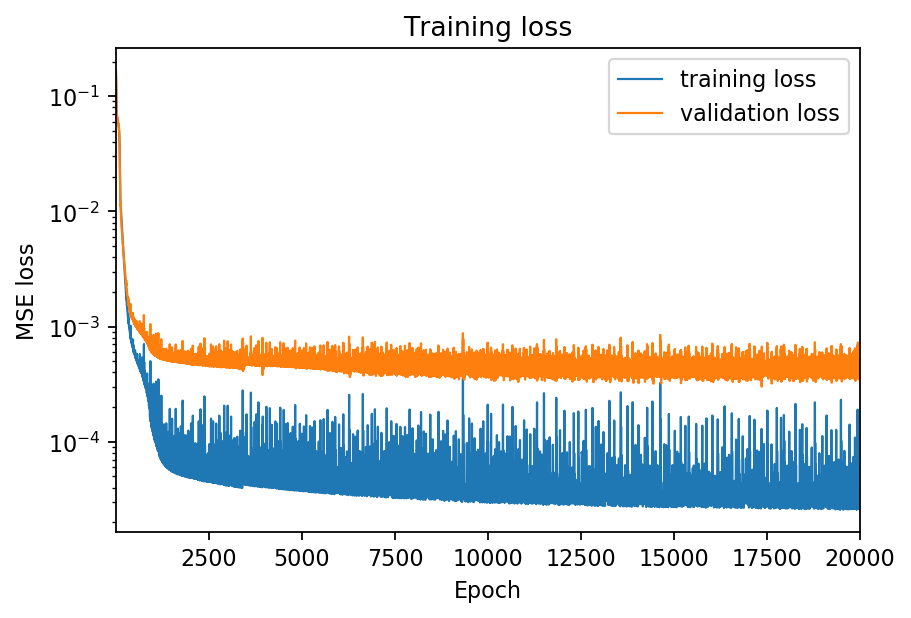

In [15]:
epochs = len(train_loss_wall)
plt.title("Training loss")
plt.plot(range(1, epochs+1), train_loss_wall, lw=1.0, label="training loss")
plt.plot(range(1, epochs+1), val_loss_wall, lw=1.0, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xlim(1, epochs+1)
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/train_val_loss_bestwall.pdf", bbox_inches="tight")

In [16]:
# Calculate L_inf again
best_model_wall = FeatureScalerModel(train_wall_minmax.min(dim=0).values, train_wall_minmax.max(dim=0).values, **model_params).double()
best_model_wall.load_state_dict(pt.load(f"{save_model_best}best_model_train.pt"))
prediction = best_model_wall(test_wall[:, 0:2]).squeeze()
l2 = (prediction - test_wall[:, 2]).square().mean()
# We normalize the maximum error with the range of the scaled dUdy and Ux_face,
# which is 1 - 0 = 1
lmax = (prediction - test_wall[:, 2]).absolute().max()
print("MSE test loss: {:1.4e}".format(l2))
print("Lmax test loss: {:1.4e}".format(lmax))

MSE test loss: 7.8151e-06
Lmax test loss: 6.1443e-02


In [17]:
# Actual prediction of wall slopes
full_data = pt.cat((reshape_features(y_face, U_center), reshape_label(dUdy_wall)), axis=1).double()

full_pred = best_model_wall(full_data[:, 0:2])
full_pred = scaler.rescale(full_pred)[:, 0]

prediction = pt.expm1(full_pred.detach())/D*Uinput

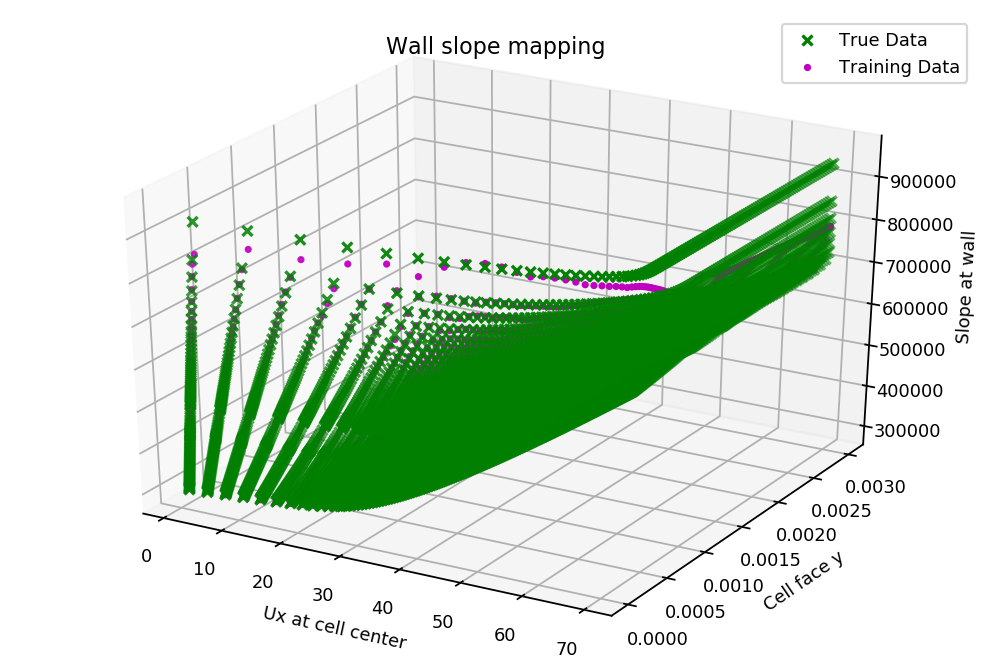

In [19]:
# Plot true label and trained model for wall slope
fig_map_best = plt.figure()
ax_map_best = Axes3D(fig_map_best)

ax_map_best.set_title('Wall slope mapping', fontsize=10)
ax_map_best.set_xlabel('Ux at cell center', fontsize=8)
ax_map_best.set_ylabel('Cell face y', fontsize=8)
ax_map_best.set_zlabel('Slope at wall', fontsize=8)
ax_map_best.xaxis.set_tick_params(labelsize=8)
ax_map_best.yaxis.set_tick_params(labelsize=8)
ax_map_best.zaxis.set_tick_params(labelsize=8)
ax_map_best.scatter(full_data[:, 1], full_data[:, 0], full_data[:, 2], color = "g", marker = "x", label = "True Data")
ax_map_best.scatter(full_data[:, 1], full_data[:, 0], prediction, color = 'm', marker = ".", label = "Training Data")
ax_map_best.legend(fontsize = 8)
plt.savefig(f"{output}/wallslopemapping_bestwall.pdf", bbox_inches="tight")

### 2-2. Save the model for OpenFOAM

In [20]:
class RescaleModel(pt.nn.Module):
    def __init__(self, model, ymin, ymax):
        super(RescaleModel, self).__init__()
        self._model = model
        self._ymin = ymin
        self._ymax = ymax
        self._yrange = ymax - ymin
        
    def inverse_scale_y(self, x):
        return x*self._yrange + self._ymin

    def forward(self, x):
        x = self._model(x)
        x = self.inverse_scale_y(x)
        # Restore the original scale from the non-dimensionalized/log labels
        x = pt.expm1(x)/D*Uinput        
        return x

In [21]:
# Base tensor for getting the min-max values of train sets
train_minmax = reshape_label(pt.log1p(dUdy_wall[:, train_idx]*D/Uinput))

distanceBasedModel = RescaleModel(best_model_wall, train_minmax.min(dim=0).values, train_minmax.max(dim=0).values).double()

# Save the combined model
save_model_distance = f"{output}/distanceBasedModel/"
!mkdir -p $save_model_distance

# Save the tracing model for OpenFOAM
traced_script_module = pt.jit.trace(distanceBasedModel, full_data[0:2, 0:2])
traced_script_module.save(f"{save_model_distance}distanceBasedModel.pt")

### 2-3. Scaling model for OpenFOAM

In [22]:
# Scale inputs in OpenFOAM
class ScaleModule(pt.nn.Module):
    def __init__(self, xmin, xmax):
        super(ScaleModule, self).__init__()
        self._xmin = xmin
        self._xmax = xmax
        self._range = xmax - xmin
        
    def scale(self, x):
        return (x - self._xmin) / self._range
    
    def forward(self, x):        
        x[:, 0] = x[:, 0]/D
        x[:, 1] = x[:, 1]/Uinput
        x = self.scale(x)        
        return x

In [23]:
scaling_features = ScaleModule(train_wall_minmax.min(dim=0).values, train_wall_minmax.max(dim=0).values).double()

# Save the combined model
save_model_scale = f"{output}/scaleModule_wallCorr/"
!mkdir -p $save_model_scale

# Save the tracing model for OpenFOAM
traced_script_module = pt.jit.trace(scaling_features, train_features[0:2, 0:2])
traced_script_module.save(f"{save_model_scale}scaleModule_wallCorr.pt")